<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Fri May 28 13:18:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

Cloning into 'segmentation-of-pelvic-bone'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 290 (delta 171), reused 181 (delta 88), pack-reused 0
Receiving objects: 100% (290/290), 4.27 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (171/171), done.
     |████████████████████████████████| 47.4MB 100kB/s 
/content/segmentation-of-pelvic-bone/src


In [6]:
!git pull

Already up to date.


In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [8]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [9]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 10.5 s, sys: 3.65 s, total: 14.1 s
Wall time: 24.7 s


In [ ]:
data.cmn_img_3c[42].shape

(291, 512, 512, 3)

In [10]:
X_train, y_train, X_val, y_val = data.X_train_3C, data.y_train, data.X_val_3C, data.y_val

## ResNet V2

In [ ]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tfk.applications.resnet_v2.preprocess_input(x)
resnet_model = tfk.applications.ResNet50V2(weights="imagenet", include_top=False, pooling="max")
resnet_output = resnet_model(x)
hidden_layer = tfkl.Dense(128, activation='relu')(resnet_output)
hl_reg = tfkl.Dropout(0.2)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_5 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0   

### Training 

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
resnet_model.trainable = False
for layer in resnet_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
checkpoint_filepath = PATH + '/checkpoint/resnet/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/50
25/25 [==============================] - 12s 338ms/step - loss: 15.2440 - acc: 0.7966 - val_loss: 5.0950 - val_acc: 0.8837
Epoch 2/50
25/25 [==============================] - 6s 239ms/step - loss: 8.0324 - acc: 0.7979 - val_loss: 5.1401 - val_acc: 0.8837
Epoch 3/50
25/25 [==============================] - 6s 239ms/step - loss: 6.2567 - acc: 0.8355 - val_loss: 1.9686 - val_acc: 0.8837
Epoch 4/50
25/25 [==============================] - 6s 238ms/step - loss: 5.1035 - acc: 0.8225 - val_loss: 1.1658 - val_acc: 0.8953
Epoch 5/50
25/25 [==============================] - 6s 238ms/step - loss: 2.7637 - acc: 0.8679 - val_loss: 0.1962 - val_acc: 0.9302
Epoch 6/50
25/25 [==============================] - 6s 239ms/step - loss: 1.8149 - acc: 0.8808 - val_loss: 0.2819 - val_acc: 0.9186
Epoch 7/50
25/25 [==============================] - 6s 239ms/step - loss: 1.1059 - acc: 0.9067 - val_loss: 0.1831 - val_acc: 0.9535
Epoch 8/50
25/25 [==============================] - 6s 238ms/step - loss: 

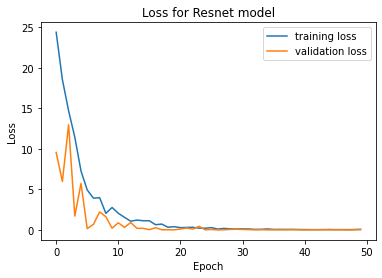

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for Resnet model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

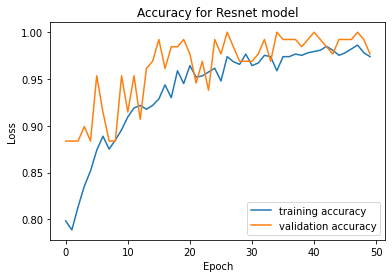

In [ ]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for Resnet model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Normal CNN

In [ ]:
X_train, X_val = tf.constant(X_train), tf.constant(X_val)
X_train, X_val = tf.image.per_image_standardization(X_train), tf.image.per_image_standardization(X_val)

In [12]:
model = tfk.Sequential([
            tfkl.InputLayer([300, 300, 3]),
            tfkl.Conv2D(32,(3,3),padding = 'same',activation = 'relu'),
            tfkl.MaxPool2D((2,2)),
            tfkl.Conv2D(64,(3,3),padding = 'same',activation = 'relu'),
            tfkl.MaxPool2D((2,2)),
            tfkl.Conv2D(128,(3,3),padding = 'same',activation = 'relu'),
            tfkl.MaxPool2D((2,2)),
            tfkl.Conv2D(256,(3,3),padding = 'same',activation = 'relu'),
            tfkl.MaxPool2D((2,2)),
            tfkl.Flatten(),
            tfkl.Dense(512,activation='relu'),
            tfkl.Dropout(0.5),
            tfkl.Dense(64,activation='relu'),
            tfkl.Dropout(0.5),
            tfkl.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])

In [13]:
checkpoint_filepath = PATH + '/checkpoint/cnn/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/25
26/26 [==============================] - 19s 96ms/step - loss: 0.5932 - acc: 0.8589 - val_loss: 0.1301 - val_acc: 0.9302
Epoch 2/25
26/26 [==============================] - 2s 63ms/step - loss: 0.1096 - acc: 0.9497 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 3/25
26/26 [==============================] - 2s 62ms/step - loss: 0.0710 - acc: 0.9730 - val_loss: 0.0523 - val_acc: 0.9767
Epoch 4/25
26/26 [==============================] - 2s 62ms/step - loss: 0.0741 - acc: 0.9706 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 5/25
26/26 [==============================] - 2s 62ms/step - loss: 0.0375 - acc: 0.9865 - val_loss: 4.3802e-04 - val_acc: 1.0000
Epoch 6/25
26/26 [==============================] - 2s 62ms/step - loss: 0.0306 - acc: 0.9914 - val_loss: 8.5157e-04 - val_acc: 1.0000
Epoch 7/25
26/26 [==============================] - 2s 63ms/step - loss: 0.0308 - acc: 0.9890 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 8/25
26/26 [==============================] - 2s 63ms/step - loss: 0

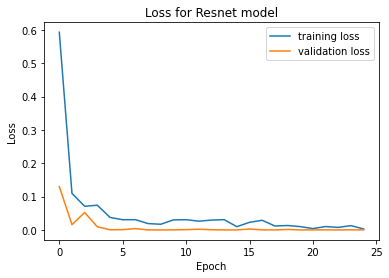

In [15]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for CNN model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

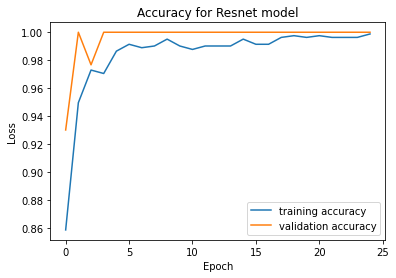

In [16]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for CNN model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Performance on Common Images

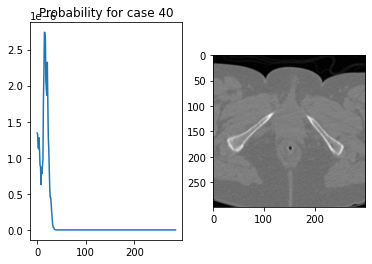

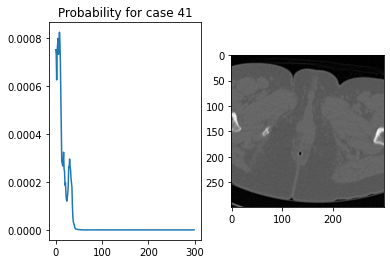

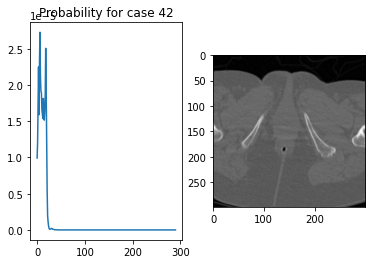

CPU times: user 5.48 s, sys: 917 ms, total: 6.39 s
Wall time: 5.96 s


In [14]:
%%time
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  X = X_flat.reshape(cmn_img.shape)
  X = np.array(
            [np.repeat(x[None, ...], 3, axis=0).T for x in X])
  y_pred = model.predict(X)
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()

# Nearest Neighbors

In [19]:
X_train, y_train, X_val, y_val = data.X_flat_train, data.y_train, data.X_flat_val, data.y_val

In [22]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(25, weights="distance")
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='distance')

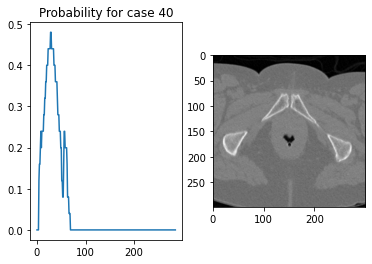

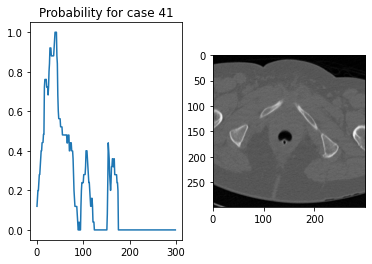

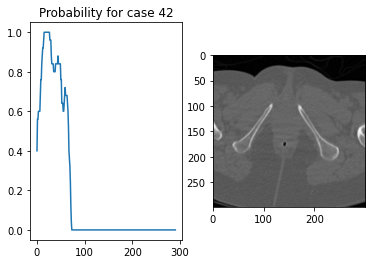

In [23]:
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  y_pred = clf.predict_proba(X_flat)[:,1]
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()